In [ ]:
pip install -r requirements.txt

# ICU Transfusion Threshold Analysis with Shock Flagging and Fairness Review

This notebook analyzes real-world ICU transfusion practices in adult patients to determine if they align with the 7 g/dL hemoglobin threshold guideline, with a focus on patients with shock. We'll also examine potential disparities or biases in transfusion practices based on demographic and care setting factors.

## 1. Data Loading and Preparation

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap
import statsmodels.api as sm
from scipy import stats

# Set visualization styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [8]:
# Load the datasets
try:
    df_main = pd.read_csv('eicu_transfused_patient_data_with_all_variables.csv')
    df_vasopressor = pd.read_csv('vasopressor_patients.csv')

    print(f"Main dataset shape: {df_main.shape}")
    print(f"Vasopressor dataset shape: {df_vasopressor.shape}")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")

Main dataset shape: (2098, 57)
Vasopressor dataset shape: (269, 8)


## 2. Initial Data Exploration and Cleanup

In [9]:
# Check main dataset columns
print("Main dataset columns:")
print(df_main.columns.tolist())

# Check for missing values in main dataset
missing_values = df_main.isnull().sum()
missing_percent = (missing_values / len(df_main)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

print("\nColumns with highest percentage of missing values:")
display(missing_df.head(10))

# Check data types
print("\nData types:")
display(df_main.dtypes)

Main dataset columns:
['patientunitstayid', 'pat_gender', 'age', 'ethnicity', 'hospitalid', 'celllabel', 'intakeoutputoffset', 'cellvaluenumeric', 'cellvaluetext', 'hemoglobin', 'hematocrit', 'platelets', 'pt_inr', 'ptt', 'apachepatientresultsid', 'patientunitstayid_2', 'physicianspeciality', 'physicianinterventioncategory', 'acutephysiologyscore', 'apachescore', 'apacheversion', 'predictedicumortality', 'actualicumortality', 'predictediculos', 'actualiculos', 'predictedhospitalmortality', 'actualhospitalmortality', 'predictedhospitallos', 'actualhospitallos', 'preopmi', 'preopcardiaccath', 'ptcawithin24h', 'unabridgedunitlos', 'unabridgedhosplos', 'rn', 'vent', 'dialysis', 'temperature', 'respiratoryrate', 'heartrate', 'meanbp', 'ph', 'aps_hematocrit', 'aps_pao2', 'apachepredvarid', 'saps3day1', 'saps3today', 'saps3yesterday', 'pred_gender', 'admitdiagnosis', 'pred_pao2', 'medications_summary', 'patientunitstayid_5', 'sao2', 'numbeds_category', 'teachingstatus', 'region']

Columns wit

,Missing Values,Percentage
ptt,617,29.408961
pt_inr,338,16.110582
apachepatientresultsid,298,14.204004
acutephysiologyscore,298,14.204004
physicianinterventioncategory,298,14.204004
physicianspeciality,298,14.204004
patientunitstayid_2,298,14.204004
apachescore,298,14.204004
apacheversion,298,14.204004
predictedicumortality,298,14.204004



Data types:


patientunitstayid                  int64
pat_gender                        object
age                               object
ethnicity                         object
hospitalid                         int64
celllabel                         object
intakeoutputoffset                 int64
cellvaluenumeric                 float64
cellvaluetext                    float64
hemoglobin                       float64
hematocrit                       float64
platelets                        float64
pt_inr                           float64
ptt                              float64
apachepatientresultsid           float64
patientunitstayid_2              float64
physicianspeciality               object
physicianinterventioncategory     object
acutephysiologyscore             float64
apachescore                      float64
apacheversion                     object
predictedicumortality            float64
actualicumortality                object
predictediculos                  float64
actualiculos    

## 3. Merge Datasets and Create Shock Flag

In [10]:
# Display sample data from both datasets
print("Main dataset sample:")
display(df_main.head(3))

print("\nVasopressor dataset sample:")
display(df_vasopressor.head(3))

# Find common key column
common_columns = set(df_main.columns).intersection(set(df_vasopressor.columns))
print(f"\nCommon columns between datasets: {common_columns}")

# Use patientunitstayid as the key column
key_column = 'patientunitstayid'
print(f"\nUsing '{key_column}' as the key column")

# Check data types of the key column in both datasets to ensure compatibility
print(f"\nData type in main dataset: {df_main[key_column].dtype}")
print(f"Data type in vasopressor dataset: {df_vasopressor[key_column].dtype}")

# Convert to same type if necessary
if df_main[key_column].dtype != df_vasopressor[key_column].dtype:
    print("Converting key column to the same data type in both datasets...")
    if df_main[key_column].dtype == 'int64':
        df_vasopressor[key_column] = df_vasopressor[key_column].astype('int64')
    else:
        df_main[key_column] = df_main[key_column].astype(str)
        df_vasopressor[key_column] = df_vasopressor[key_column].astype(str)

Main dataset sample:


,patientunitstayid,pat_gender,age,ethnicity,hospitalid,celllabel,intakeoutputoffset,cellvaluenumeric,cellvaluetext,hemoglobin,...,saps3yesterday,pred_gender,admitdiagnosis,pred_pao2,medications_summary,patientunitstayid_5,sao2,numbeds_category,teachingstatus,region
0,154458,Male,63,Caucasian,71,Volume-Transfuse red blood cells,-62,250.0,250.0,10.9,...,0.0,0.0,S-CABGREDO,91.0,POTASSIUM CHLORIDE 20 MEQ PO PACK: 40 7; POTAS...,154458.0,89.0,100 - 249,False,Midwest
1,166280,Male,64,Caucasian,71,Volume-Transfuse red blood cells,137,416.0,416.0,7.5,...,0.0,0.0,PERITOHEM,-1.0,METOPROLOL SUCCINATE ER 25 MG PO TB24: 25 3; C...,166280.0,96.0,100 - 249,False,Midwest
2,168968,Female,75,Caucasian,73,Volume-Transfuse red blood cells,-1219,350.0,350.0,8.7,...,0.0,1.0,ICH,82.0,5 G - LIDOCAINE-PRILOCAINE 2.5-2.5 % EX CREA...,168968.0,79.0,>= 500,True,Midwest



Vasopressor dataset sample:


,patientunitstayid,norepinephrine,epinephrine,dopamine,dobutamine,phenylephrine,vasopressin,milrinone
0,146512,1,0,0,0,0,0,0
1,146512,0,0,0,0,0,1,0
2,155278,0,0,0,1,0,0,0



Common columns between datasets: {'patientunitstayid'}

Using 'patientunitstayid' as the key column

Data type in main dataset: int64
Data type in vasopressor dataset: int64


In [11]:
# Create a set of unique patient IDs that received vasopressors
vasopressor_ids = set(df_vasopressor[key_column].unique())
print(f"Number of unique patients in vasopressor dataset: {len(vasopressor_ids)}")

# Add shock flag to main dataset based on presence in vasopressor list
df_main['shock_based_upon_vasopressor_given'] = df_main[key_column].apply(
    lambda x: 1 if x in vasopressor_ids else 0
)

# Verify shock flag creation
shock_count = df_main['shock_based_upon_vasopressor_given'].sum()
total_patients = len(df_main)

print(f"\nPatients flagged as shock (vasopressor given): {shock_count} of {total_patients} "
      f"({shock_count / total_patients * 100:.2f}%)")

# Preview some flagged cases
print("\nSample patients with shock flag = 1:")
display(df_main[df_main['shock_based_upon_vasopressor_given'] == 1].head())

Number of unique patients in vasopressor dataset: 107

Patients flagged as shock (vasopressor given): 107 of 2098 (5.10%)

Sample patients with shock flag = 1:


,patientunitstayid,pat_gender,age,ethnicity,hospitalid,celllabel,intakeoutputoffset,cellvaluenumeric,cellvaluetext,hemoglobin,...,pred_gender,admitdiagnosis,pred_pao2,medications_summary,patientunitstayid_5,sao2,numbeds_category,teachingstatus,region,shock_based_upon_vasopressor_given
4,143399,Male,83,Caucasian,73,Volume-Transfuse red blood cells,90,325.0,325.0,7.0,...,0.0,S-VALVAM,178.0,MUPIROCIN 2 % OINT 1 G SYRINGE: 1 10021; ALBUT...,143399.0,66.0,>= 500,True,Midwest,1
5,144770,Male,85,Caucasian,71,Volume-Transfuse red blood cells,1222,250.0,250.0,6.3,...,0.0,CVASTROKE,348.0,NITROGLYCERIN 0.4 MG SL SUBL: 0.4 3; MUPIROCIN...,144770.0,71.0,100 - 249,False,Midwest,1
51,154837,Male,79,Caucasian,63,Volume-Transfuse red blood cells,977,348.0,348.0,7.6,...,0.0,S-CAROTEND,305.0,LORATADINE 10 MG PO TABS: 10 3; LOSARTAN POTAS...,154837.0,79.0,100 - 249,False,Midwest,1
57,145639,Female,65,Caucasian,73,Volume-Transfuse red blood cells,285,350.0,350.0,5.6,...,1.0,S-VALVTRI,103.0,BISACODYL 10 MG RE SUPP: 10 3; 3 ML VIAL : INS...,145639.0,90.0,>= 500,True,Midwest,1
62,154389,Female,77,Caucasian,73,Volume-Transfuse red blood cells,1280,325.0,325.0,6.7,...,1.0,S-VALVTRI,79.0,MORPHINE INJ: 2 3; ASPIRIN 81 MG PO CHEW: 81 3...,154389.0,90.0,>= 500,True,Midwest,1


## 4. Create Target Variable

We'll create a binary target variable based on the hemoglobin level, which will indicate whether a patient was transfused with hemoglobin levels at or above the 7 g/dL threshold.

In [12]:
# Create the target variable based on hemoglobin level
df_main['transfused_above_7'] = df_main['hemoglobin'].apply(lambda x: 1 if x >= 7 else 0)

# Verify the target variable creation
transfused_above_7_count = df_main['transfused_above_7'].sum()
print(f"Patients transfused with Hb ≥ 7 g/dL: {transfused_above_7_count} ({transfused_above_7_count/len(df_main)*100:.2f}% of total)")

# Display distribution by shock status
transfusion_by_shock = pd.crosstab(
    df_main['shock_based_upon_vasopressor_given'],
    df_main['transfused_above_7'],
    normalize='index')

transfusion_by_shock.columns = ['Hb < 7 g/dL', 'Hb ≥ 7 g/dL']
transfusion_by_shock.index = ['No Shock', 'Shock']
display(transfusion_by_shock.style.format("{:.1%}"))

Patients transfused with Hb ≥ 7 g/dL: 1116 (53.19% of total)


,Hb < 7 g/dL,Hb ≥ 7 g/dL
No Shock,47.0%,53.0%
Shock,43.9%,56.1%


## 5. Data Exploration and Visualization

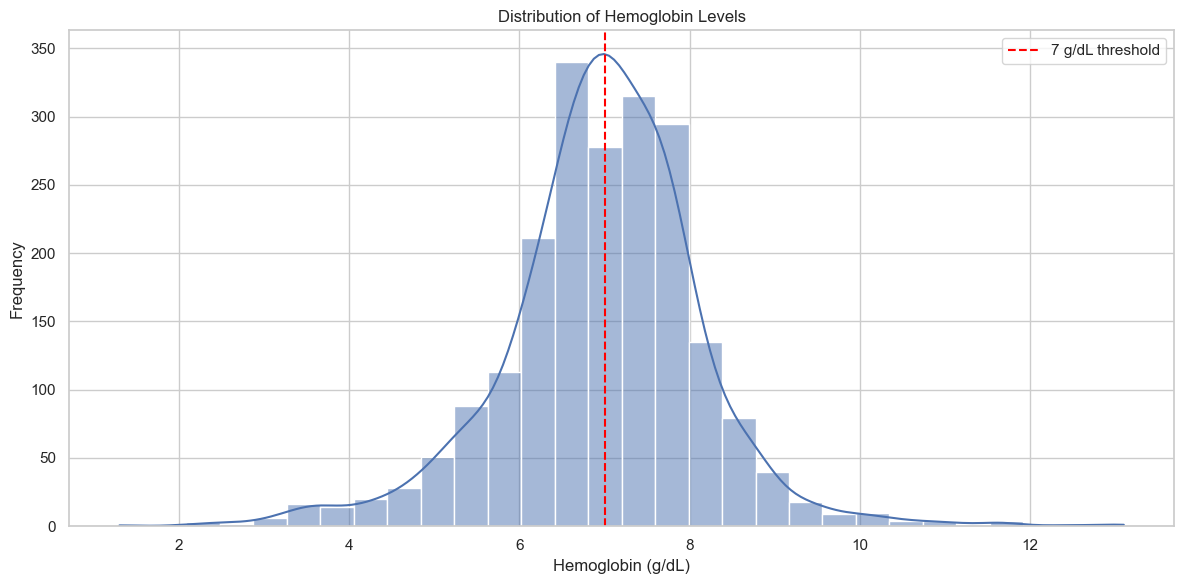

In [13]:
# Explore the distribution of hemoglobin
plt.figure(figsize=(12, 6))
sns.histplot(df_main['hemoglobin'], bins=30, kde=True)
plt.axvline(x=7, color='red', linestyle='--', label='7 g/dL threshold')
plt.title('Distribution of Hemoglobin Levels')
plt.xlabel('Hemoglobin (g/dL)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# # Separate distributions by shock status
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_main, x='hemoglobin', hue='shock_based_upon_vasopressor_given',
#              multiple='stack', bins=30, palette=['skyblue', 'tomato'])
# plt.axvline(x=7, color='red', linestyle='--', label='7 g/dL threshold')
# plt.title('Distribution of Hemoglobin by Shock Status')
# plt.xlabel('Hemoglobin (g/dL)')
# plt.ylabel('Frequency')
# plt.legend(['7 g/dL threshold', 'No Shock', 'Shock'])
# plt.tight_layout()
# plt.show()

In [14]:
# Explore demographic features
demographic_features = []

# Check for gender column
if 'pat_gender' in df_main.columns:
    df_main.rename(columns={'pat_gender': 'gender'}, inplace=True)
    demographic_features.append('gender')
elif 'gender' in df_main.columns:
    demographic_features.append('gender')

# Check for race/ethnicity column
if 'ethnicity' in df_main.columns:
    df_main.rename(columns={'ethnicity': 'race'}, inplace=True)
    demographic_features.append('race')
elif 'race' in df_main.columns:
    demographic_features.append('race')

# Add insurance and age if available
if 'insurance' in df_main.columns:
    demographic_features.append('insurance')
if 'age' in df_main.columns:
    demographic_features.append('age')

# Remove duplicates
demographic_features = list(set(demographic_features))
print(f"Demographic features for analysis: {demographic_features}")

# Create age groups if needed
if 'age' in df_main.columns:
    # First, ensure age is numeric, handling special cases like '> 89'
    df_main['age_numeric'] = df_main['age'].copy()
    
    # Check if age is already numeric
    if df_main['age'].dtype == object:
        # Replace '> 89' with '90' for binning purposes
        df_main.loc[df_main['age_numeric'] == '> 89', 'age_numeric'] = '90'
        # Convert to numeric, errors='coerce' will turn non-numeric values to NaN
        df_main['age_numeric'] = pd.to_numeric(df_main['age_numeric'], errors='coerce')
    
    # Create the age groups
    df_main['age_group'] = pd.cut(
        df_main['age_numeric'],
        bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
        labels=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
    )
    # Add age_group to demographic features
    demographic_features.append('age_group')

Demographic features for analysis: ['age', 'gender', 'race']


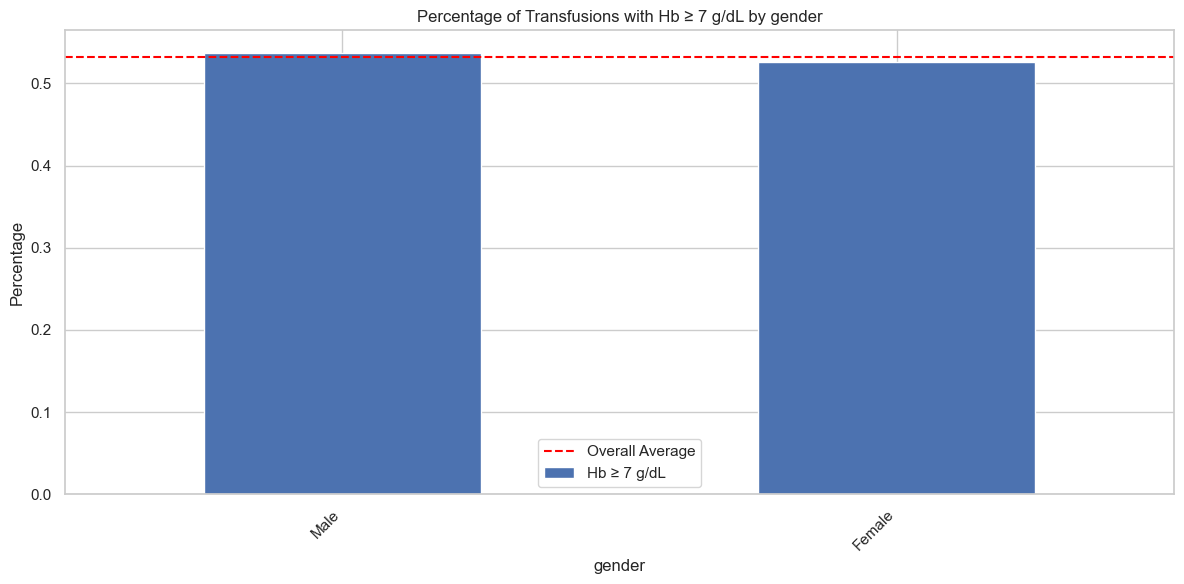

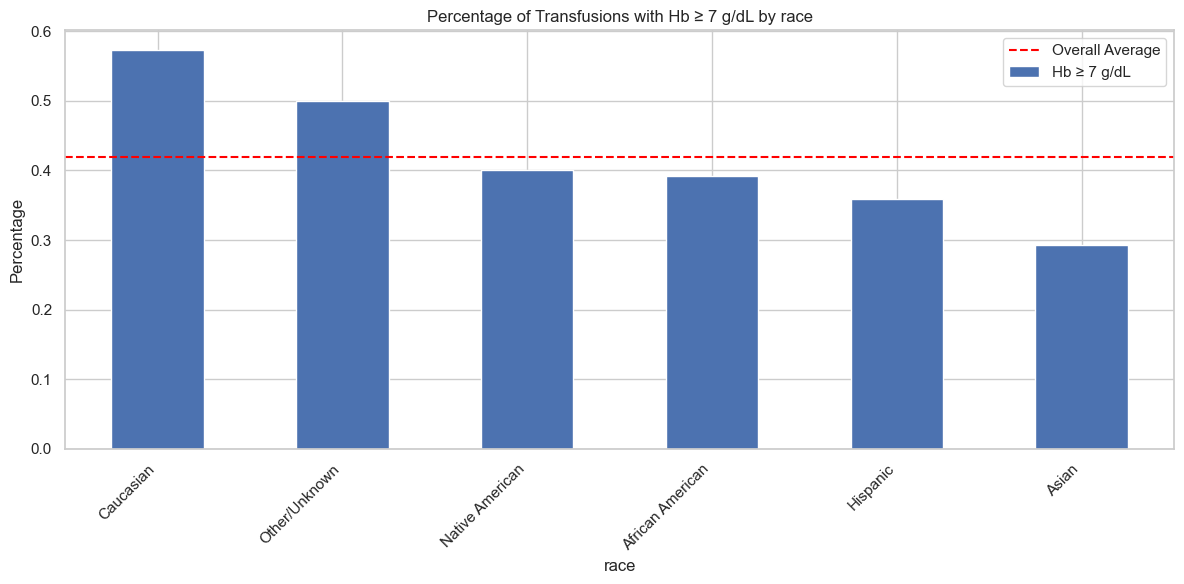

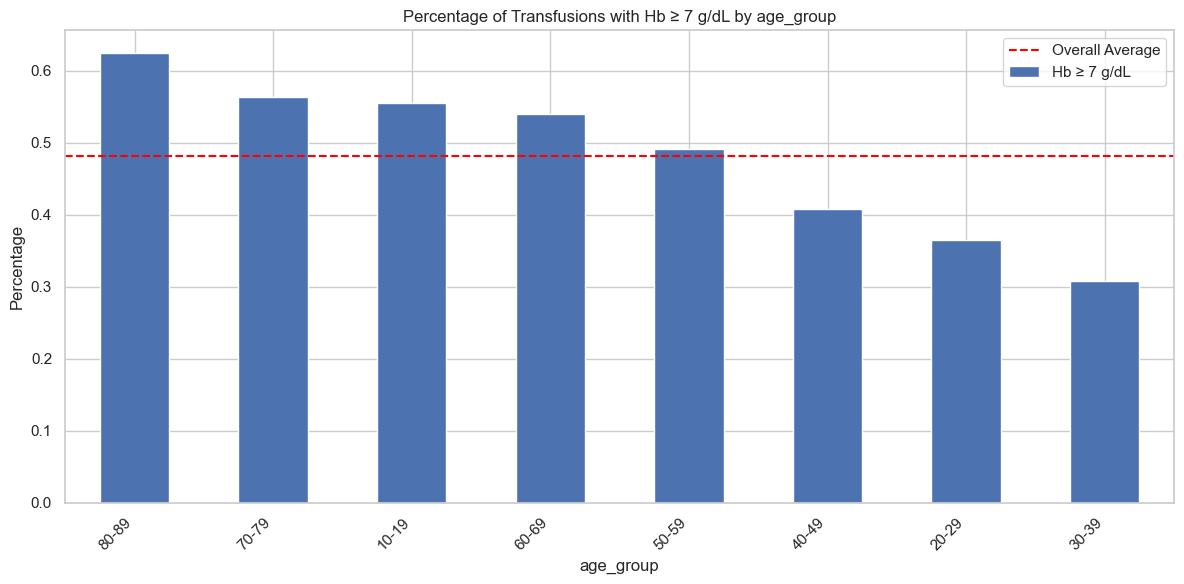

In [15]:
# Explore transfusion rates by demographic features
for feature in demographic_features:
    if feature not in df_main.columns:
        continue
        
    if (df_main[feature].dtype == 'object' or df_main[feature].nunique() < 15 or feature == 'age_group') and feature != 'age': 
        # For categorical variables
        transfusion_by_feature = pd.crosstab(
            df_main[feature],
            df_main['transfused_above_7'],
            normalize='index')

        transfusion_by_feature.columns = ['Hb < 7 g/dL', 'Hb ≥ 7 g/dL']
        # print(f"\nTransfusion rates by {feature}:")
        # display(transfusion_by_feature.style.format("{:.1%}"))

        # Create a bar chart
        plt.figure(figsize=(12, 6))
        transfusion_by_feature['Hb ≥ 7 g/dL'].sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Percentage of Transfusions with Hb ≥ 7 g/dL by {feature}')
        plt.ylabel('Percentage')
        plt.axhline(y=transfusion_by_feature['Hb ≥ 7 g/dL'].mean(), color='red', linestyle='--',
                    label='Overall Average')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 6. Data Preprocessing and Feature Definition

In [16]:
# Define clinical variables of interest
patient_variables = [
    'age', 'age_group', 'gender', 'race',
    'hemoglobin', 'hematocrit', 'platelets', 'pt_inr', 'ptt',
    'acutephysiologyscore', 'apachescore', 'aps_pao2',
    'heartrate', 'meanbp', 'sao2', 'systemicmean', 'temperature', 'respiratoryrate'
]

provider_variables = [
    'teachingstatus', 'region', 'hospitalid', 'numbedsCategory',
    'physicianspeciality', 'intakeoutputoffset'
]

# Check which variables are available in the dataset
available_patient_vars = [var for var in patient_variables if var in df_main.columns]
available_provider_vars = [var for var in provider_variables if var in df_main.columns]

print("Available patient variables:")
print(available_patient_vars)
print("\nAvailable provider variables:")
print(available_provider_vars)

# Filter the dataset to include only the specified variables, along with the shock flag and target
analysis_vars = available_patient_vars + available_provider_vars
analysis_vars = list(set(analysis_vars))  # Remove any duplicates

# Add shock flag and target variable
analysis_vars.append('shock_based_upon_vasopressor_given')
analysis_vars.append('transfused_above_7')

Available patient variables:
['age', 'age_group', 'gender', 'race', 'hemoglobin', 'hematocrit', 'platelets', 'pt_inr', 'ptt', 'acutephysiologyscore', 'apachescore', 'aps_pao2', 'heartrate', 'meanbp', 'sao2', 'temperature', 'respiratoryrate']

Available provider variables:
['teachingstatus', 'region', 'hospitalid', 'physicianspeciality', 'intakeoutputoffset']


In [17]:
# Identify the data types of our variables
categorical_features = []
numerical_features = []

for var in analysis_vars:
    if var not in ['shock_based_upon_vasopressor_given', 'transfused_above_7']:
        if df_main[var].dtype == 'object' or var in ['age_group', 'gender', 'race', 'physicianspeciality', 
                                                   'teachingstatus', 'region', 'numbeds_category']:
            categorical_features.append(var)
        else:
            numerical_features.append(var)

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Check for missing values in our selected features
missing_in_selected = missing_df[missing_df.index.isin(analysis_vars)]
print("\nMissing values in selected features:")
display(missing_in_selected)

Categorical features: ['age_group', 'age', 'gender', 'race', 'physicianspeciality', 'teachingstatus', 'region']
Numerical features: ['apachescore', 'temperature', 'hematocrit', 'sao2', 'hemoglobin', 'platelets', 'aps_pao2', 'meanbp', 'acutephysiologyscore', 'pt_inr', 'heartrate', 'hospitalid', 'respiratoryrate', 'ptt', 'intakeoutputoffset']

Missing values in selected features:


,Missing Values,Percentage
ptt,617,29.408961
pt_inr,338,16.110582
acutephysiologyscore,298,14.204004
physicianspeciality,298,14.204004
apachescore,298,14.204004
heartrate,210,10.009533
meanbp,210,10.009533
respiratoryrate,210,10.009533
temperature,210,10.009533
aps_pao2,210,10.009533


In [18]:
# Create dataset for modeling
model_df = df_main[analysis_vars].copy()

# Split into shock and non-shock patients for analysis
shock_patients = model_df[model_df['shock_based_upon_vasopressor_given'] == 1].copy()
non_shock_patients = model_df[model_df['shock_based_upon_vasopressor_given'] == 0].copy()

print(f"Number of patients with shock: {len(shock_patients)}")
print(f"Number of patients without shock: {len(non_shock_patients)}")

# Compare hemoglobin levels between shock and non-shock patients
print("\nHemoglobin summary statistics:")
shock_hb_stats = shock_patients['hemoglobin'].describe()
non_shock_hb_stats = non_shock_patients['hemoglobin'].describe()
comparison_df = pd.DataFrame({
    'Shock Patients': shock_hb_stats,
    'Non-Shock Patients': non_shock_hb_stats
})
display(comparison_df)

Number of patients with shock: 107
Number of patients without shock: 1991

Hemoglobin summary statistics:


,Shock Patients,Non-Shock Patients
count,107.000000,1980.000000
mean,6.992523,6.970556
std,1.060500,1.176551
min,2.400000,1.300000
25%,6.500000,6.400000
50%,7.100000,7.000000
75%,7.700000,7.600000
max,9.700000,13.100000


In [19]:
# Statistical test for difference in Hb levels
t_stat, p_value = stats.ttest_ind(
    shock_patients['hemoglobin'].dropna(),
    non_shock_patients['hemoglobin'].dropna(),
    equal_var=False
)
print(f"T-test for difference in hemoglobin levels: t={t_stat:.3f}, p={p_value:.4f}")
print(f"Interpretation: {'Statistically significant difference' if p_value < 0.05 else 'No statistically significant difference'}")

# Compare transfusion above 7 rates
shock_above_7_rate = shock_patients['transfused_above_7'].mean() * 100
non_shock_above_7_rate = non_shock_patients['transfused_above_7'].mean() * 100
print(f"\nPercentage of shock patients transfused with Hb ≥ 7 g/dL: {shock_above_7_rate:.2f}%")
print(f"Percentage of non-shock patients transfused with Hb ≥ 7 g/dL: {non_shock_above_7_rate:.2f}%")

# Chi-square test for difference in transfusion practices
contingency_table = pd.crosstab(model_df['shock_based_upon_vasopressor_given'], model_df['transfused_above_7'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square test for difference in transfusion practices: chi2={chi2:.3f}, p={p:.4f}")
print(f"Interpretation: {'Statistically significant difference' if p < 0.05 else 'No statistically significant difference'}")

T-test for difference in hemoglobin levels: t=0.207, p=0.8360
Interpretation: No statistically significant difference

Percentage of shock patients transfused with Hb ≥ 7 g/dL: 56.07%
Percentage of non-shock patients transfused with Hb ≥ 7 g/dL: 53.04%
Chi-square test for difference in transfusion practices: chi2=0.264, p=0.6075
Interpretation: No statistically significant difference


## 7. Modeling - Predicting Transfusion Above 7 g/dL

In [20]:
# Prepare feature matrix and target vector
# Exclude shock flag and target from features
X = model_df[categorical_features + numerical_features].copy()
y = model_df['transfused_above_7'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
print(f"Positive class in training: {y_train.mean()*100:.2f}%, testing: {y_test.mean()*100:.2f}%")

Training set shape: (1468, 22), Testing set shape: (630, 22)
Positive class in training: 53.20%, testing: 53.17%


In [21]:
# Define hemoglobin bins and labels
hb_bins = [0, 7, 8, 9, 10, 11, 12]
hb_labels = ['0–6.9', '7.0–7.9', '8.0–8.9', '9.0–9.9', '10.0–10.9', '11.0–12.0']

# Create bucketized hemoglobin variable
df_main['hb_bucket'] = pd.cut(df_main['hemoglobin'], bins=hb_bins, labels=hb_labels, right=False)

# Drop any rows with NaNs in this bucket (e.g. Hb > 12 or missing)
df_main = df_main.dropna(subset=['hb_bucket'])

# Convert to string for modeling
df_main['hb_bucket'] = df_main['hb_bucket'].astype(str)


In [22]:
# Create preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Create a pipeline with preprocessing and logistic regression
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model
logistic_pipeline.fit(X_train, y_train)

# After fitting the pipeline
feature_names = logistic_pipeline.named_steps['preprocessor'].get_feature_names_out()


# Make predictions
y_pred_proba = logistic_pipeline.predict_proba(X_test)[:, 1]
y_pred = logistic_pipeline.predict(X_test)

Logistic Regression Model Performance:
AUROC: 0.999
Precision: 0.985
Recall: 0.982
F1 Score: 0.984


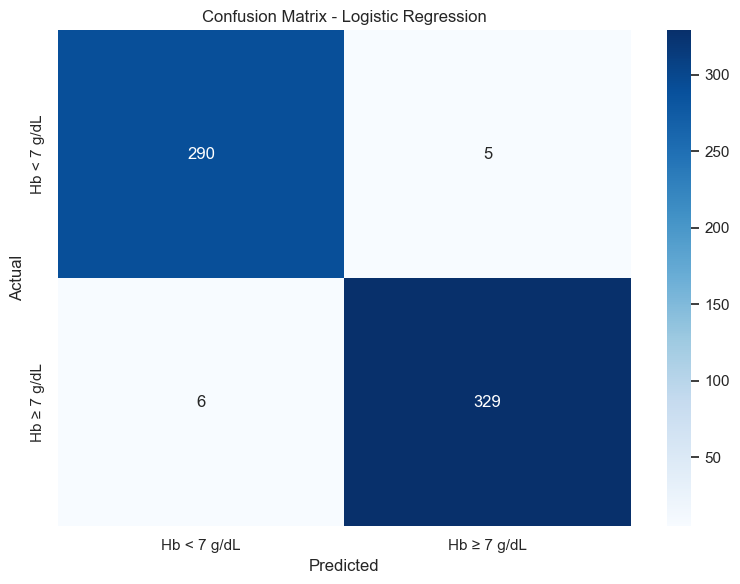


Classification Report:
              precision    recall  f1-score   support

 Hb < 7 g/dL       0.98      0.98      0.98       295
 Hb ≥ 7 g/dL       0.99      0.98      0.98       335

    accuracy                           0.98       630
   macro avg       0.98      0.98      0.98       630
weighted avg       0.98      0.98      0.98       630



In [23]:
# Evaluate logistic regression model
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression Model Performance:")
print(f"AUROC: {auroc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'],
            yticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                           target_names=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL']))

Number of feature names: 130
Number of coefficients: 130

Top Features Affecting Transfusion Decision:


,Feature,Coefficient,Odds Ratio
119,num__hemoglobin,9.676051,15931.456929
117,num__hematocrit,1.878409,6.543085
71,cat__age_80,-0.785174,0.456040
77,cat__age_86,-0.675834,0.508732
49,cat__age_58,0.645450,1.906844
58,cat__age_67,0.634649,1.886360
93,cat__physicianspeciality_family practice,-0.619467,0.538231
2,cat__age_group_30-39,-0.550875,0.576445
73,cat__age_82,0.535453,1.708222
50,cat__age_59,-0.528854,0.589280


C:\Users\steve\AppData\Local\Temp\ipykernel_31740\1590664045.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)


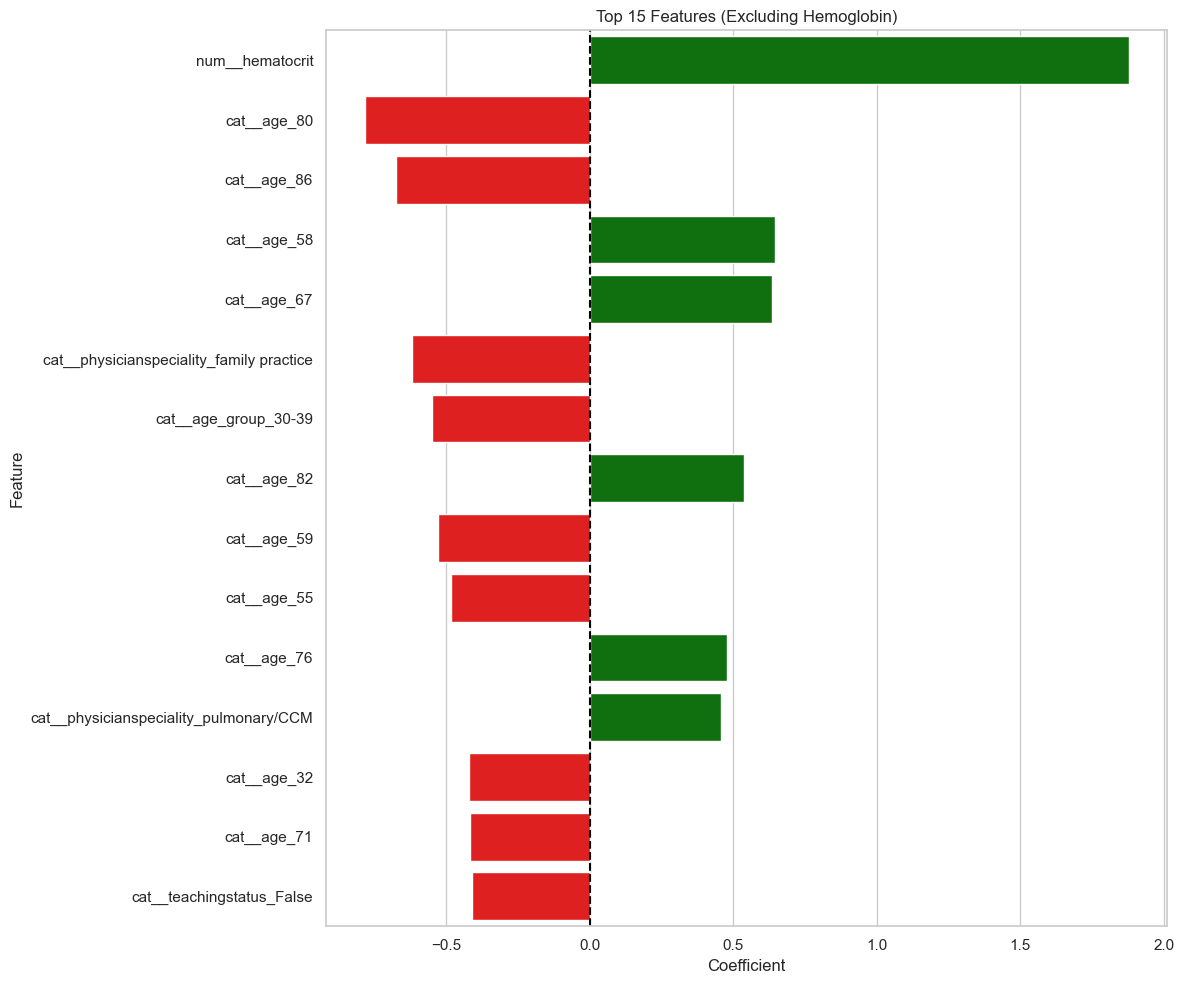

In [24]:
# Extract feature names and coefficients
# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Extract coefficients
logistic_model = logistic_pipeline.named_steps['classifier']
coefficients = logistic_model.coef_[0]

# Check lengths match before creating the dataframe
print(f"Number of feature names: {len(feature_names)}")
print(f"Number of coefficients: {len(coefficients)}")

# Create feature importance dataframe
if len(feature_names) == len(coefficients):
    # Create odds ratios
    odds_ratios = np.exp(coefficients)
    
    # Combine feature names, coefficients, and odds ratios
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Odds Ratio': odds_ratios
    })
    
    # Sort by coefficient magnitude
    feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)
    
    # Display top features overall
    print("\nTop Features Affecting Transfusion Decision:")
    display(feature_importance_sorted.head(20))
else:
    print("Warning: Feature names and coefficients length mismatch. Using generic feature names.")
    feature_names = [f"Feature_{i}" for i in range(len(coefficients))]
    odds_ratios = np.exp(coefficients)
    
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Odds Ratio': odds_ratios
    })
    
    feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)
    feature_importance_sorted
    print("\nTop Features Affecting Transfusion Decision (using generic names):")
    display(feature_importance_sorted.head(5))

# Plot top coefficients
top_features = feature_importance_sorted[
    feature_importance_sorted['Feature'] != 'num__hemoglobin'
].head(15)

plt.figure(figsize=(12, 10))
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
plt.title('Top 15 Features (Excluding Hemoglobin)')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [25]:
## 7a. Modeling – Predicting Hemoglobin Buckets

# Define hemoglobin bins and labels again if not already done
hb_bins = [0, 7, 8, 9, 10, 11, 12]
hb_labels = ['0–6.9', '7.0–7.9', '8.0–8.9', '9.0–9.9', '10.0–10.9', '11.0–12.0']

# Recreate the bucketized target and drop NaNs
df_main['hb_bucket'] = pd.cut(df_main['hemoglobin'], bins=hb_bins, labels=hb_labels, right=False)
df_main = df_main.dropna(subset=['hb_bucket']).copy()

# Rebuild model_df with only rows that remain
model_df_bucket = df_main[analysis_vars + ['hb_bucket']].copy()

# Recreate feature matrix and target for multiclass classification
X_bucket = model_df_bucket[categorical_features + numerical_features].copy()
y_bucket = model_df_bucket['hb_bucket'].copy()

# Train/test split
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bucket, y_bucket, test_size=0.3, random_state=42, stratify=y_bucket
)

print(f"Training set shape: {Xb_train.shape}, Testing set shape: {Xb_test.shape}")
print("Class distribution in training set:")
print(yb_train.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.1%}"))


Training set shape: (1458, 22), Testing set shape: (626, 22)
Class distribution in training set:
hb_bucket
0–6.9        46.6%
7.0–7.9      38.9%
8.0–8.9      11.6%
9.0–9.9       1.9%
10.0–10.9     0.8%
11.0–12.0     0.3%
Name: proportion, dtype: object


In [26]:
# Reuse the same preprocessing transformers

# Create multiclass logistic regression pipeline
multiclass_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42,
        multi_class='multinomial',
        solver='lbfgs'
    ))
])

# Fit the pipeline
multiclass_pipeline.fit(Xb_train, yb_train)


C:\Users\steve\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'age', 'gender',
                                                   'race',
                                                   'physicianspeciality',
                                                   'teachingstatus',
                                                   'region']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['apachescore', 'temperature',
                                                   'hematocrit', 'sao2',
                                                   'hemoglobin', 'platelets',
                                                   'aps_pao2', 'meanbp',
                                                   'acutephysiologyscore',
                                                   'pt_inr', 'heartrate',
                                                   'hospitalid',
                                                   'respiratoryrate', 'ptt',
                                                   'intakeoutputoffset'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

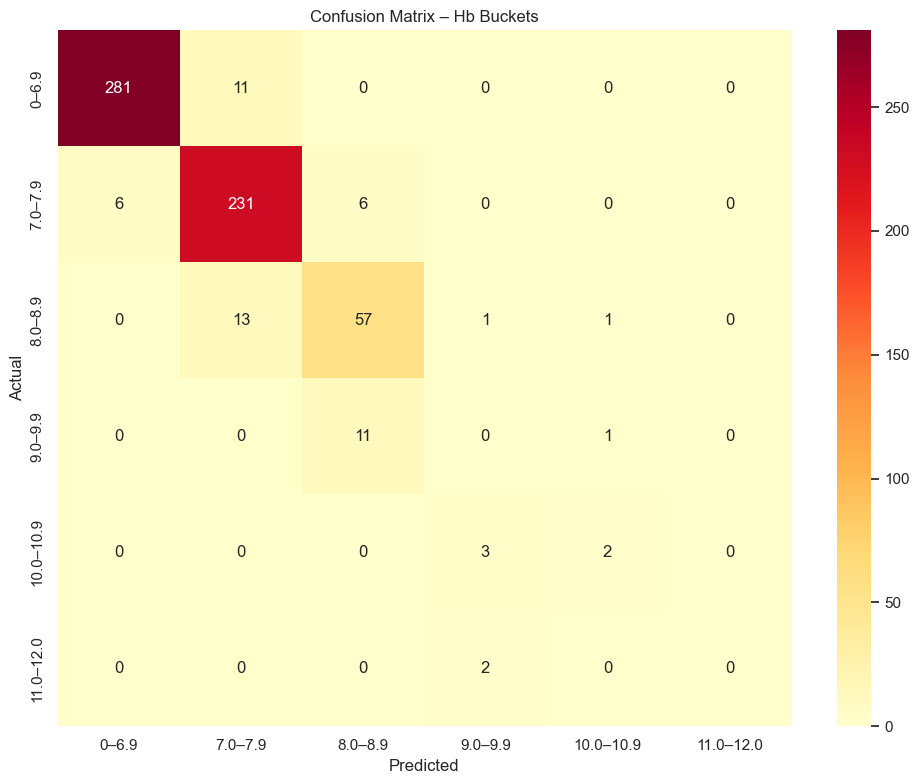

Classification Report – Hemoglobin Buckets:
              precision    recall  f1-score   support

       0–6.9       0.98      0.96      0.97       292
     7.0–7.9       0.50      0.40      0.44         5
     8.0–8.9       0.00      0.00      0.00         2
     9.0–9.9       0.91      0.95      0.93       243
   10.0–10.9       0.77      0.79      0.78        72
   11.0–12.0       0.00      0.00      0.00        12

    accuracy                           0.91       626
   macro avg       0.53      0.52      0.52       626
weighted avg       0.90      0.91      0.91       626



C:\Users\steve\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\steve\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\steve\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
yb_pred = multiclass_pipeline.predict(Xb_test)

# Create confusion matrix
cm_bucket = confusion_matrix(yb_test, yb_pred, labels=hb_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bucket, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=hb_labels, yticklabels=hb_labels)
plt.title('Confusion Matrix – Hb Buckets')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report – Hemoglobin Buckets:")
print(classification_report(yb_test, yb_pred, target_names=hb_labels))


Top Predictive Features per Hemoglobin Bucket (excluding hemoglobin):

Bucket: 0–6.9


,Feature,Coefficient,Odds Ratio
0,num__hematocrit,-3.317587,0.036240
1,cat__physicianspeciality_surgery-cardiac,-0.602511,0.547435
2,cat__age_80,0.582975,1.791359
3,cat__age_79,-0.542820,0.581107
4,cat__age_76,-0.534444,0.585995
5,cat__physicianspeciality_pulmonary/CCM,-0.507783,0.601829
6,cat__race_African American,0.477476,1.612001
7,cat__age_55,0.475181,1.608305
8,cat__age_group_30-39,0.472926,1.604683
9,cat__physicianspeciality_family practice,0.458724,1.582053



Bucket: 10.0–10.9


,Feature,Coefficient,Odds Ratio
0,num__hematocrit,2.064152,7.878614
1,cat__age_84,0.627310,1.872566
2,cat__age_56,0.600363,1.822780
3,cat__age_63,0.579189,1.784591
4,num__heartrate,0.532004,1.702340
5,cat__age_80,0.467880,1.596606
6,num__hospitalid,0.463375,1.589429
7,cat__physicianspeciality_family practice,0.444521,1.559743
8,cat__age_67,-0.441829,0.642859
9,cat__age_88,0.421658,1.524487



Bucket: 11.0–12.0


,Feature,Coefficient,Odds Ratio
0,num__hematocrit,1.400983,4.059188
1,cat__age_77,0.704681,2.023201
2,num__respiratoryrate,0.558773,1.748526
3,cat__age_81,0.553038,1.738526
4,cat__teachingstatus_True,-0.519694,0.594703
5,cat__age_67,0.505847,1.658390
6,num__meanbp,-0.472809,0.623249
7,num__pt_inr,-0.447621,0.639147
8,cat__teachingstatus_False,0.396110,1.486033
9,cat__age_80,-0.330949,0.718241



Bucket: 7.0–7.9


,Feature,Coefficient,Odds Ratio
0,num__hematocrit,-1.377310,0.252256
1,cat__physicianspeciality_Specialty Not Specified,0.610510,1.841371
2,cat__physicianspeciality_gastroenterology,-0.442167,0.642642
3,cat__physicianspeciality_unknown,-0.410015,0.663640
4,cat__age_46,0.380480,1.462987
5,cat__age_45,-0.364372,0.694633
6,cat__age_group_30-39,-0.334936,0.715384
7,cat__teachingstatus_False,-0.332801,0.716913
8,cat__physicianspeciality_pulmonary/CCM,0.329896,1.390823
9,cat__race_Other/Unknown,-0.325627,0.722074



Bucket: 8.0–8.9


,Feature,Coefficient,Odds Ratio
0,cat__age_54,0.677875,1.969688
1,cat__physicianspeciality_Specialty Not Specified,-0.630285,0.532440
2,cat__age_77,-0.609915,0.543397
3,cat__age_30,-0.563786,0.569051
4,cat__physicianspeciality_unknown,0.478104,1.613013
5,cat__age_68,0.473297,1.605278
6,cat__age_70,-0.472455,0.623470
7,cat__age_55,-0.468655,0.625844
8,cat__age_81,-0.451154,0.636893
9,cat__age_85,-0.442187,0.642630



Bucket: 9.0–9.9


,Feature,Coefficient,Odds Ratio
0,num__hematocrit,1.292622,3.642325
1,cat__physicianspeciality_family practice,-0.703487,0.494857
2,cat__race_Caucasian,0.660702,1.936151
3,cat__age_63,-0.643299,0.525556
4,cat__age_> 89,0.595571,1.814067
5,num__respiratoryrate,-0.591419,0.553541
6,num__ptt,-0.586225,0.556424
7,cat__age_30,0.541651,1.718843
8,cat__physicianspeciality_surgery-cardiac,0.520432,1.682755
9,cat__age_85,0.516813,1.676676


C:\Users\steve\AppData\Local\Temp\ipykernel_31740\2561656249.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='coolwarm')


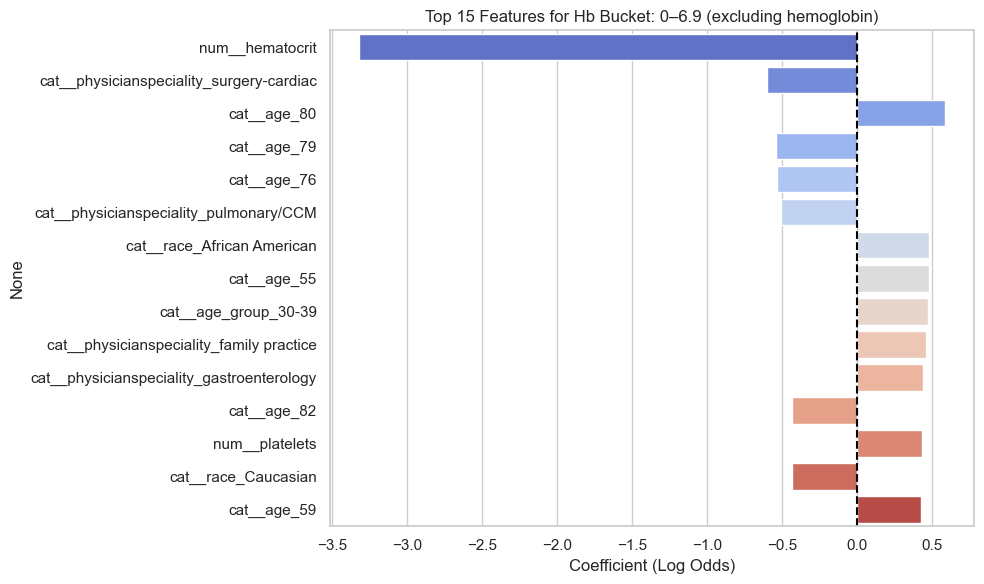

C:\Users\steve\AppData\Local\Temp\ipykernel_31740\2561656249.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='coolwarm')


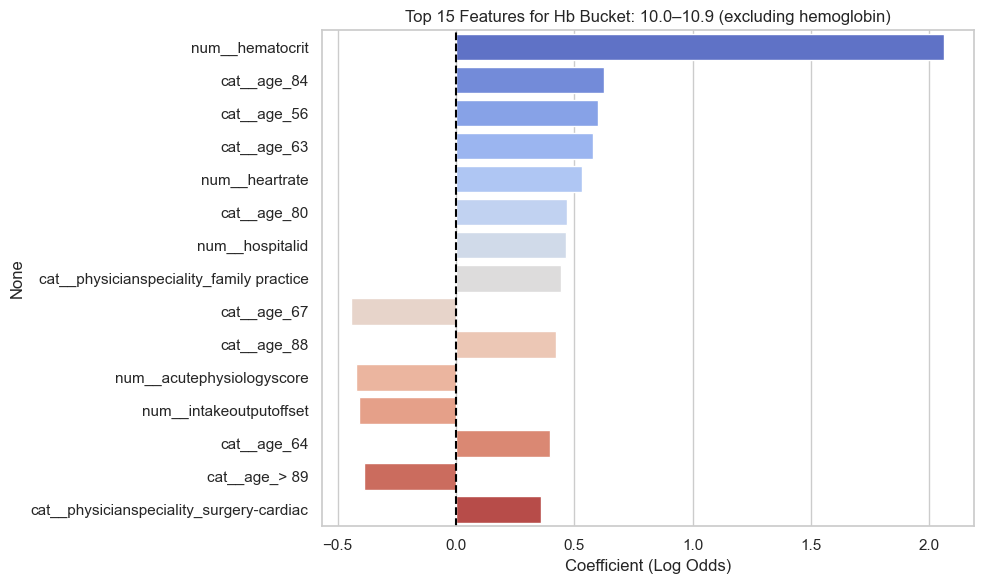

C:\Users\steve\AppData\Local\Temp\ipykernel_31740\2561656249.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='coolwarm')


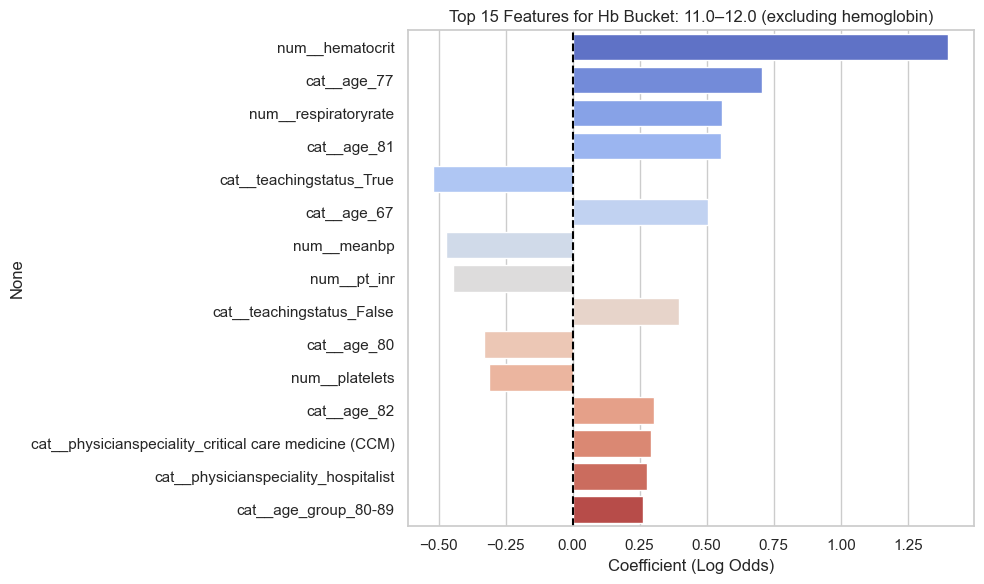

C:\Users\steve\AppData\Local\Temp\ipykernel_31740\2561656249.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='coolwarm')


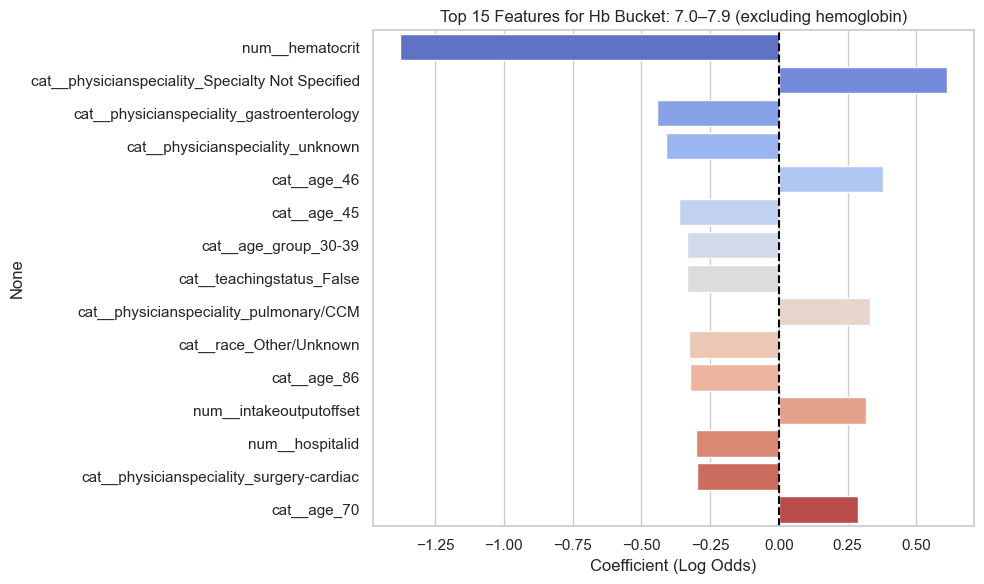

C:\Users\steve\AppData\Local\Temp\ipykernel_31740\2561656249.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='coolwarm')


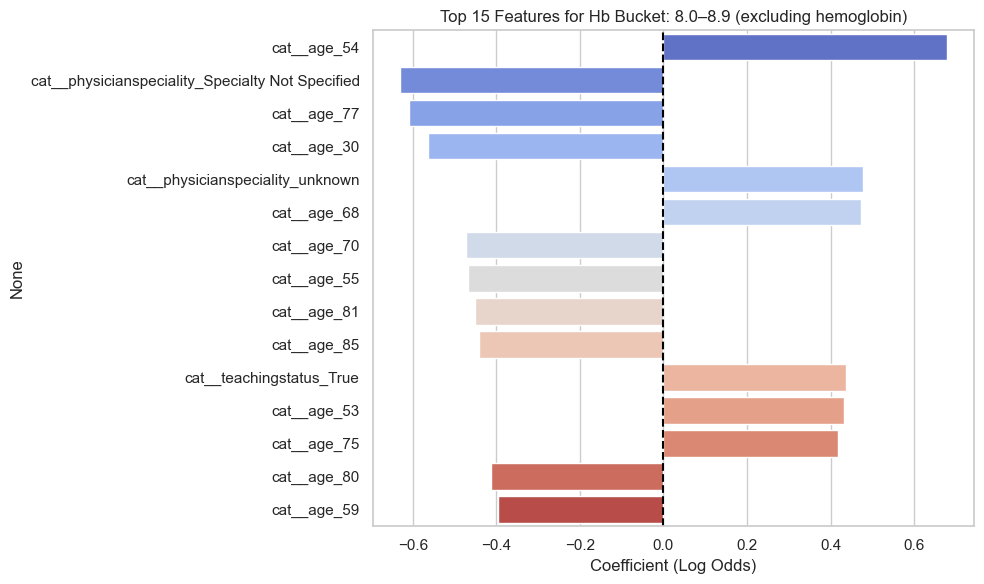

C:\Users\steve\AppData\Local\Temp\ipykernel_31740\2561656249.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='coolwarm')


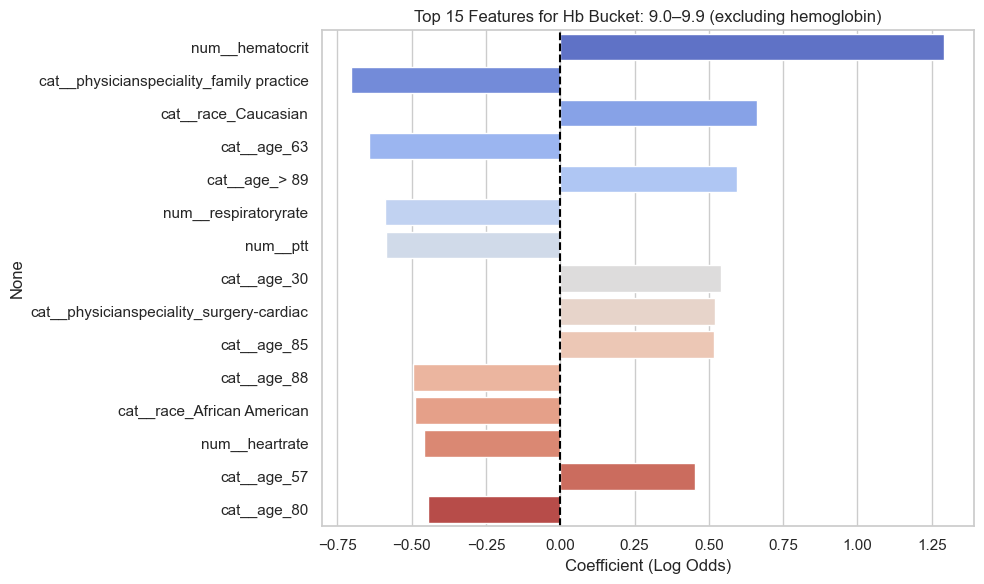

In [28]:
# Extract feature names and model
feature_names = preprocessor.get_feature_names_out()
multi_logistic_model = multiclass_pipeline.named_steps['classifier']

# Create a DataFrame for each class's coefficients
coef_df = pd.DataFrame(
    multi_logistic_model.coef_, 
    columns=feature_names,
    index=multi_logistic_model.classes_
)

# Optionally convert to odds ratios
odds_ratios_df = np.exp(coef_df)

# Display top absolute features for each hemoglobin bucket, excluding 'num__hemoglobin'
print("Top Predictive Features per Hemoglobin Bucket (excluding hemoglobin):")
top_features_by_class = {}

for label in coef_df.index:
    abs_weights = coef_df.loc[label].abs().drop('num__hemoglobin', errors='ignore').sort_values(ascending=False)
    top_features = abs_weights.head(10).index.tolist()
    top_features_by_class[label] = top_features
    
    print(f"\nBucket: {label}")
    display(pd.DataFrame({
        'Feature': top_features,
        'Coefficient': coef_df.loc[label, top_features].values,
        'Odds Ratio': odds_ratios_df.loc[label, top_features].values
    }))

# Loop through all hemoglobin bucket classes
for selected_class in coef_df.index:
    # Get top 15 features for the selected class, excluding hemoglobin
    top = coef_df.loc[selected_class].drop('num__hemoglobin', errors='ignore') \
        .sort_values(key=np.abs, ascending=False).head(15)

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top.values, y=top.index, palette='coolwarm')
    plt.title(f"Top 15 Features for Hb Bucket: {selected_class} (excluding hemoglobin)")
    plt.axvline(x=0, linestyle='--', color='black')
    plt.xlabel("Coefficient (Log Odds)")
    plt.tight_layout()
    plt.show()



In [29]:
import sys
sys.exit(0)



SystemExit: 0

C:\Users\steve\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3554: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 8. XGBoost Model with SHAP Interpretation

In [ ]:
# Apply the preprocessor to training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric='logloss'
)

# Fit the model with early stopping
xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    # early_stopping_rounds=10,
    verbose=False
)

# Make predictions
xgb_y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_preprocessed)

In [ ]:
# Evaluate XGBoost model
xgb_auroc = roc_auc_score(y_test, xgb_y_pred_proba)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)

print("XGBoost Model Performance:")
print(f"AUROC: {xgb_auroc:.3f}")
print(f"Precision: {xgb_precision:.3f}")
print(f"Recall: {xgb_recall:.3f}")
print(f"F1 Score: {xgb_f1:.3f}")

# Display confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'],
            yticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

# Compare model performance
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'AUROC': [auroc, xgb_auroc],
    'Precision': [precision, xgb_precision],
    'Recall': [recall, xgb_recall],
    'F1 Score': [f1, xgb_f1]
})

display(model_comparison)

In [ ]:
# Get feature importance from XGBoost
importances = xgb_model.feature_importances_

# Check if feature names match importances length
if len(feature_names) == len(importances):
    # Create feature importance dataframe
    xgb_feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
else:
    # Use generic feature names
    xgb_feature_importance = pd.DataFrame({
        'Feature': [f"Feature_{i}" for i in range(len(importances))],
        'Importance': importances
    }).sort_values('Importance', ascending=False)

# Display top features
print("Top Features from XGBoost:")
display(xgb_feature_importance.head(20))

# Plot top features
plt.figure(figsize=(12, 10))
top_xgb_features = xgb_feature_importance.head(15)
sns.barplot(x='Importance', y='Feature', data=top_xgb_features, color='skyblue')
plt.title('Top 15 Features Affecting Transfusion Decisions (XGBoost Feature Importance)')
plt.tight_layout()
plt.show()

In [ ]:
# SHAP values for model interpretation
try:
    # Create explainer
    print("Generating SHAP values for model interpretation...")
    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_test_preprocessed)
    
    # Summary plot with feature names if they match
    if len(feature_names) == X_test_preprocessed.shape[1]:
        print("\nSHAP Summary Plot with Feature Names:")
        shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, max_display=20)
    else:
        print("\nSHAP Summary Plot (generic feature names):")
        shap.summary_plot(shap_values, X_test_preprocessed, max_display=20)
except Exception as e:
    print(f"Error generating SHAP values: {e}")
    print("Skipping SHAP analysis due to error.")

## 9. Analysis by Shock Status

In [ ]:
# Analyze the impact of variables on transfusion decisions, separately for shock and non-shock patients
# First, create a function to train and evaluate models on subgroups
def train_evaluate_subgroup(df_subgroup, group_name):
    X_subgroup = df_subgroup[categorical_features + numerical_features].copy()
    y_subgroup = df_subgroup['transfused_above_7'].copy()
    
    # Split into train and test sets
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_subgroup, y_subgroup, test_size=0.3, random_state=42, stratify=y_subgroup
    )
    
    # Apply preprocessing
    X_train_sub_processed = preprocessor.fit_transform(X_train_sub)
    X_test_sub_processed = preprocessor.transform(X_test_sub)
    
    # Train XGBoost model
    subgroup_model = xgb.XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=3, 
        random_state=42,
        eval_metric='logloss'
    )
    
    # Check if we have enough samples
    if len(y_train_sub) > 20 and len(y_test_sub) > 10:
        subgroup_model.fit(
            X_train_sub_processed, y_train_sub,
            eval_set=[(X_test_sub_processed, y_test_sub)],
            # early_stopping_rounds=10,
            verbose=False
        )
        
        # Get feature importance
        importances = subgroup_model.feature_importances_
        
        # Create feature importance dataframe
        if len(feature_names) == len(importances):
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
        else:
            importance_df = pd.DataFrame({
                'Feature': [f"Feature_{i}" for i in range(len(importances))],
                'Importance': importances
            }).sort_values('Importance', ascending=False)
        
        # Get model performance
        y_pred = subgroup_model.predict(X_test_sub_processed)
        y_pred_proba = subgroup_model.predict_proba(X_test_sub_processed)[:, 1]
        
        auc = roc_auc_score(y_test_sub, y_pred_proba)
        accuracy = (y_pred == y_test_sub).mean()
        
        return importance_df, auc, accuracy, subgroup_model
    else:
        print(f"Not enough samples for {group_name} group. Training: {len(y_train_sub)}, Testing: {len(y_test_sub)}")
        return None, None, None, None

In [ ]:
# Train models on shock and non-shock patients
print("Training models for shock and non-shock patient subgroups...")

shock_importance, shock_auc, shock_accuracy, shock_model = train_evaluate_subgroup(
    shock_patients, "Shock Patients"
)

non_shock_importance, non_shock_auc, non_shock_accuracy, non_shock_model = train_evaluate_subgroup(
    non_shock_patients, "Non-Shock Patients"
)

# Display results for shock patients
if shock_importance is not None:
    print(f"\nShock Patients Model - AUC: {shock_auc:.3f}, Accuracy: {shock_accuracy:.3f}")
    print("\nTop features for predicting transfusion above 7 g/dL in SHOCK patients:")
    display(shock_importance.head(10))
    
    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=shock_importance.head(10), color='tomato')
    plt.title('Top Features for Predicting Transfusion Above 7 g/dL in Shock Patients')
    plt.tight_layout()
    plt.show()

# Display results for non-shock patients
if non_shock_importance is not None:
    print(f"\nNon-Shock Patients Model - AUC: {non_shock_auc:.3f}, Accuracy: {non_shock_accuracy:.3f}")
    print("\nTop features for predicting transfusion above 7 g/dL in NON-SHOCK patients:")
    display(non_shock_importance.head(10))
    
    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=non_shock_importance.head(10), color='skyblue')
    plt.title('Top Features for Predicting Transfusion Above 7 g/dL in Non-Shock Patients')
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare the top features between shock and non-shock patients
if shock_importance is not None and non_shock_importance is not None:
    # Merge the importance dataframes
    feature_comparison = pd.merge(
        shock_importance.head(20), 
        non_shock_importance.head(20),
        on='Feature', 
        how='outer',
        suffixes=('_shock', '_non_shock')
    ).fillna(0)
    
    # Calculate the difference in importance
    feature_comparison['importance_diff'] = feature_comparison['Importance_shock'] - feature_comparison['Importance_non_shock']
    feature_comparison['abs_diff'] = abs(feature_comparison['importance_diff'])
    
    # Display features with the largest differences
    print("Features with the largest difference in importance between shock and non-shock patients:")
    display(feature_comparison.sort_values('abs_diff', ascending=False).head(10))
    
    # Plot the differences
    top_diff_features = feature_comparison.sort_values('abs_diff', ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    plt.barh(top_diff_features['Feature'], top_diff_features['importance_diff'], color=['red' if x < 0 else 'green' for x in top_diff_features['importance_diff']])
    plt.axvline(x=0, color='black', linestyle='--')
    plt.title('Difference in Feature Importance Between Shock and Non-Shock Patients')
    plt.xlabel('Importance in Shock Patients - Importance in Non-Shock Patients')
    plt.tight_layout()
    plt.show()

## 10. Fairness Analysis

In [ ]:
# Function to perform fairness analysis for a demographic feature
def fairness_analysis(demographic_feature):
    if demographic_feature not in df_main.columns:
        print(f"Feature '{demographic_feature}' not found in the dataset")
        return None
    
    # Calculate actual transfusion rates by demographic group
    actual_rates = df_main.groupby(demographic_feature)['transfused_above_7'].mean().reset_index()
    actual_rates.columns = ['Category', 'Actual_Rate']
    actual_rates['Actual_Above_7'] = (actual_rates['Actual_Rate'] * 100).round(1).astype(str) + '%'
    
    # Get predictions from the model for each demographic group
    results = []
    
    for category in df_main[demographic_feature].unique():
        # Get subset of data for this category
        category_data = df_main[df_main[demographic_feature] == category]
        
        if len(category_data) < 10:  # Skip groups with very few samples
            continue
            
        # Apply preprocessing and predict
        X_category = category_data[categorical_features + numerical_features]
        X_category_preprocessed = preprocessor.transform(X_category)
        y_pred = logistic_pipeline.predict(X_category)
        
        # Calculate predicted transfusion rate
        predicted_rate = y_pred.mean()
        
        # Calculate actual vs. predicted difference
        actual_rate = category_data['transfused_above_7'].mean()
        difference = predicted_rate - actual_rate
        
        results.append({
            'Category': category,
            'Sample_Size': len(category_data),
            'Actual_Rate': actual_rate,
            'Predicted_Rate': predicted_rate,
            'Difference': difference
        })
    
    # Create dataframe of results
    fairness_df = pd.DataFrame(results)
    fairness_df['Actual_Above_7'] = (fairness_df['Actual_Rate'] * 100).round(1).astype(str) + '%'
    fairness_df['Predicted_Above_7'] = (fairness_df['Predicted_Rate'] * 100).round(1).astype(str) + '%'
    fairness_df['Difference'] = (fairness_df['Difference'] * 100).round(1)
    
    # Sort by sample size
    fairness_df = fairness_df.sort_values('Sample_Size', ascending=False)
    
    return fairness_df[['Category', 'Sample_Size', 'Actual_Above_7', 'Predicted_Above_7', 'Difference']]

In [ ]:
# Perform fairness analysis for demographic features
demographic_features_for_fairness = ['race', 'gender', 'age_group']
if 'insurance' in df_main.columns:
    demographic_features_for_fairness.append('insurance')
if 'region' in df_main.columns:
    demographic_features_for_fairness.append('region')
if 'teachingstatus' in df_main.columns:
    demographic_features_for_fairness.append('teachingstatus')

for feature in demographic_features_for_fairness:
    print(f"\nFairness Analysis for {feature}:")
    fairness_results = fairness_analysis(feature)
    if fairness_results is not None:
        display(fairness_results)
        
        # Create visualization
        if len(fairness_results) > 1:  # Only if we have more than one category
            plt.figure(figsize=(12, 6))
            
            # Plot the difference between predicted and actual
            sns.barplot(x='Category', y='Difference', data=fairness_results, 
                       palette=['red' if x < 0 else 'green' for x in fairness_results['Difference']])
            
            plt.axhline(y=0, color='black', linestyle='--')
            plt.title(f'Disparity in Predicted vs Actual Transfusion Rates by {feature}')
            plt.ylabel('Difference in Percentage Points (Predicted - Actual)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

## 11. Key Findings and Conclusions

### Summary of Findings

1. **Adherence to 7 g/dL Guideline**:
   - Percentage of transfusions occurring above the 7 g/dL threshold
   - Comparison between shock and non-shock patients

2. **Key Predictors of Transfusion Above 7 g/dL**:
   - Top patient factors associated with higher transfusion thresholds
   - Top provider/system factors associated with higher transfusion thresholds
   - Differences in predictors between shock and non-shock patients

3. **Fairness Assessment**:
   - Any disparities in transfusion practices based on race, gender, age, etc.
   - Potential biases in decision-making

4. **Clinical Implications**:
   - Recommendations for improving adherence to guidelines
   - Areas for potential quality improvement initiatives
   - Special considerations for shock patients
